Bu kodlar google colabda gpuni qushgan holatda o'qitildi.
GPU: T4, GPU RAM 15.0 GB ||
System RAM: 12.7 GB

In [1]:
!pip install cuda-python
!pip install ultralytics
!pip install tensorrt
!pip install onnx
!pip install ipython

In [5]:
import cv2
import numpy as np
import tensorrt as trt
from cuda import cudart
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from google.colab import drive
from ultralytics import YOLO
import onnx
import torch

In [6]:
!cp /content/drive/MyDrive/Colab_Notebooks/tensorrt/RT/models/cudart_api.py /content
!cp /content/drive/MyDrive/Colab_Notebooks/tensorrt/RT/models/api.py /content
!cp /content/drive/MyDrive/Colab_Notebooks/tensorrt/RT/models/common.py /content
!cp /content/drive/MyDrive/Colab_Notebooks/tensorrt/RT/models/engine.py /content
!cp /content/drive/MyDrive/Colab_Notebooks/tensorrt/RT/models/pycuda_api.py /content
!cp /content/drive/MyDrive/Colab_Notebooks/tensorrt/RT/models/torch_utils.py /content
!cp /content/drive/MyDrive/Colab_Notebooks/tensorrt/RT/models/utils.py /content

In [7]:
from utils import blob
from torch_utils import det_postprocess
from cudart_api import TRTEngine
from engine import EngineBuilder

In [9]:
import sys
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/tensorrt/RT') # from models.common import PostDetect, optim buni ishlatish uchun kerak

In [10]:
from models.common import PostDetect, optim

try:
    import onnxsim
except ImportError:
    onnxsim = None

from io import BytesIO

PostDetect.conf_thres = 0.25
PostDetect.iou_thres = 0.65
PostDetect.topk = 100

.pt modelni .onnx modelga o'tkazish kodi

In [ ]:
model_name = "/content/drive/MyDrive/Colab_Notebooks/tensorrt/best.pt"
input_shape = (1,3,640,640)

b = input_shape[0]

Yolo_model = YOLO(model_name)
model = Yolo_model.model.fuse().eval()

device = "cuda:0"

for m in model.modules():
    optim(m)
    m.to(device)

model.to(device)

fake_input = torch.randn(input_shape).to(device)
for _ in range(2):
    model(fake_input)

save_path = model_name.replace('.pt', '.onnx')

with BytesIO() as f:
    torch.onnx.export(
        model,
        fake_input,
        f,
        opset_version=11,
        input_names=['images'],
        output_names=['num_dets', 'bboxes', 'scores', 'labels'])
    f.seek(0)
    onnx_model = onnx.load(f)
onnx.checker.check_model(onnx_model)

shapes = [b, 1, b, 100 , 4, b, 100 , b, 100]

for i in onnx_model.graph.output:
    for j in i.type.tensor_type.shape.dim:
        j.dim_param = str(shapes.pop(0))
#if args.sim:
try:
    onnx_model, check = onnxsim.simplify(onnx_model)
    assert check, 'assert check failed'

except Exception as e:
    print(f'Simplifier failure: {e}')

onnx.save(onnx_model, save_path)
print(f'ONNX export success, saved as {save_path}')

Model summary (fused): 168 layers, 11125971 parameters, 0 gradients


In [18]:
builder = EngineBuilder("/content/drive/MyDrive/Colab_Notebooks/tensorrt/best.onnx", device)
builder.seg = True
builder.build(fp16=True,
              input_shape=list(input_shape),
              iou_thres=0.65,
              conf_thres=0.25,
              topk=100)

In [15]:
def ImageBox(image, new_shape=(640, 640), color=(0, 0, 0)):

    width, height, channel = image.shape

    ratio = min(new_shape[0] / width, new_shape[1] / height)

    new_unpad = int(round(height * ratio)), int(round(width * ratio))

    dw, dh = (new_shape[0] - new_unpad[0])/2, (new_shape[1] - new_unpad[1])/2

    if (height, width) != new_unpad:
        image = cv2.resize(image, new_unpad, interpolation=cv2.INTER_LINEAR)

    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))

    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return image, ratio, (dw, dh)

.engine modelini load qilish kodi

In [12]:
enggine = TRTEngine('/content/drive/MyDrive/Colab_Notebooks/tensorrt/best.engine')
H, W = enggine.inp_info[0].shape[-2:]

-1

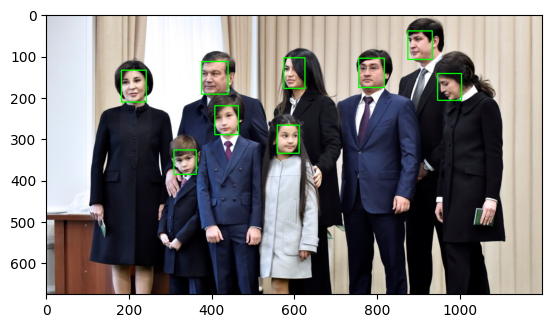

In [18]:
# Rasmni sinovdan o'tkazish uchun

frame = cv2.imread("/content/drive/MyDrive/Colab_Notebooks/tensorrt/president.jpg")
image, ratio, dwdh = ImageBox(frame)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

tensor = blob(image, return_seg=False)
tensor = torch.asarray(tensor)

dwdh = np.array(dwdh * 2, dtype=np.float32)

results = enggine(tensor)

bboxes, scores, labels = det_postprocess(results)
bboxes = (bboxes-dwdh)/ratio
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
for (bbox, score, label) in zip(bboxes, scores, labels):
    bbox = bbox.round().astype(np.int32).tolist()
    cv2.rectangle(frame, (bbox[0],bbox[1]) , (bbox[2],bbox[3]) , (0,255,0), 2)
plt.imshow(frame)
#cv2.imshow("input", frame)
cv2.waitKey(0)

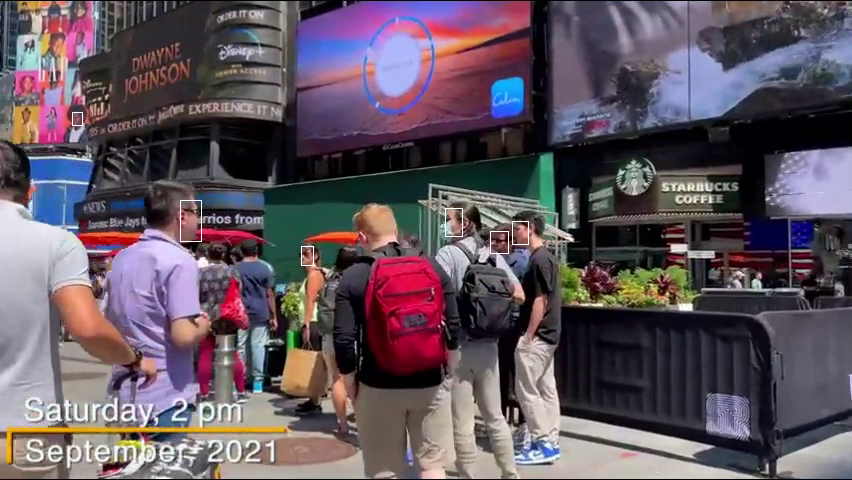

AttributeError: ignored

In [31]:
B# Videoni sinovdan o'tkazish uchun
from IPython.display import clear_output
import time
video = cv2.VideoCapture('/content/drive/MyDrive/Colab_Notebooks/tfmodel/vid.mp4')

width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

while True:

    ret, frame = video.read()

    image, ratio, dwdh = ImageBox(frame)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    tensor = blob(image, return_seg=False)
    tensor = torch.asarray(tensor)

    results = enggine(tensor)

    dwdh = np.array(dwdh * 2, dtype=np.float32)

    bboxes, scores, labels = det_postprocess(results)
    bboxes = (bboxes-dwdh)/ratio

    for (bbox, score, label) in zip(bboxes, scores, labels):
        bbox = bbox.round().astype(np.int32).tolist()
        cv2.rectangle(frame, (bbox[0],bbox[1]) , (bbox[2],bbox[3]) , (255,255,255), 1)
    clear_output(wait=True)
    cv2_imshow(frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()